In [1]:
import os, json, pickle, math
import pandas as pd
import numpy as np
from collections import defaultdict

## Question asking response ratio

In [2]:
total_cnt, cnt = 0, 0

for split in ["train", "valid", "test"]:
    raw = json.load(open(f'./data/msc_dialogue/session_1/{split}.json'))
    for dial in raw:
        for utt in dial["utterances"]:
            if utt["id"] == "Speaker 2":
                total_cnt += 1
                if "?" in utt["text"].strip():
                    cnt += 1                

In [3]:
PROB_BUCKET_GIVEN_QN = cnt/total_cnt
print(PROB_BUCKET_GIVEN_QN)

0.3007824069503406


# is_question

In [4]:
spk_dict = defaultdict(lambda: "<user>")
spk_dict["Speaker 2"] = "<agent>"

In [5]:
# defined at controllable_generation code (See, Abigail, et al. 2019)

def get_qn_bucket_probs(buck_num=10):
    """
    Assuming we have 11 CT question buckets (0 to 10), compute P(bucket|question=1) and
    P(bucket|question=0); this is needed so we can probabilistically assign incoming
    training examples to buckets.

    Returns:
      prob_bucket_given_qn: list of floats length 11; P(bucket|question=1)
      prob_bucket_given_notqn: list of floats length 11; P(bucket|question=0)
    """
    prob_qn = cnt/total_cnt  # P(question=1), computed across ConvAI2 dataset. ~31%

    # Compute P(bucket), i.e. the total sizes of the buckets.
    # This is done by assuming that buckets 1 to 10 are equal in size, but bucket 0
    # is larger because we have more non-questions than questions. Therefore:
    # P(question=1) = P(bucket=1, question=1) + ... + P(bucket=10, question=1)
    #               = prob_bucket_n * 0.1 + ... + prob_bucket_n * 1
    #               = 5.5 * prob_bucket_n
    # Thus we can derive the value for prob_bucket_n and prob_bucket_0:
    total_prob = (buck_num+1)/2
    prob_bucket_n = prob_qn / total_prob  # P(bucket=n) for n=1,...,10
    prob_bucket_0 = 1 - buck_num * prob_bucket_n  # P(bucket=0)
    prob_bucket = [prob_bucket_0] + [prob_bucket_n] * buck_num  # list length 11, P(bucket)

    # Compute P(bucket|qn=1) and P(bucket|qn=0) using Bayes Rule:
    # P(bucket|qn=1) = P(bucket) * P(qn=1|bucket) / P(qn=1)
    # P(bucket|qn=0) = P(bucket) * P(qn=0|bucket) / P(qn=0)
    prob_bucket_given_qn = [pb * (i / buck_num) / prob_qn for i, pb in enumerate(prob_bucket)]
    prob_bucket_given_notqn = [
        pb * ((buck_num - i) / buck_num) / (1 - prob_qn) for i, pb in enumerate(prob_bucket)
    ]

    return prob_bucket_given_qn, prob_bucket_given_notqn

def set_bucket(ctrl, ctrl_val, num_buckets):
    if ctrl == "question":
        is_qn = bool(ctrl_val == 1)
        if is_qn:  # Sample from P(bucket|qn=1)
            out = np.random.choice(range(num_buckets), 1, p=PROB_BUCKET_GIVEN_QN)
        else:  # Sample from P(bucket|qn=0)
            out = np.random.choice(range(num_buckets), 1, p=PROB_BUCKET_GIVEN_NOTQN)
        out = int(out[0])
    return out

# Set bucket number

In [6]:
buck_num=10
PROB_BUCKET_GIVEN_QN, PROB_BUCKET_GIVEN_NOTQN = get_qn_bucket_probs(buck_num)

In [7]:
[round(ele, 3) for ele in PROB_BUCKET_GIVEN_QN]

[0.0, 0.018, 0.036, 0.055, 0.073, 0.091, 0.109, 0.127, 0.145, 0.164, 0.182]

In [8]:
def generate_sessN_dataset(sess, split):
    if sess == "session_1":
        utt_key = "utterances"
        raw_js = json.load(open(f'./data/msc_dialogue/{sess}/{split}.json'))
    else:
        utt_key = "dialog"
        raw_js = []
        with open(f'./data/msc_dialogue/{sess}/{split}.txt') as f:
            for line in f:
                if line is not None:
                    raw_js.append(json.loads(line))
                
    datasets = []
    for id_ele, ele in enumerate(raw_js):
        if sess == "session_1":
            user_prof = " ".join([clean_dot(ee) for ee in ele["personas"][0] if len(ee)>1])
            agent_prof = " ".join([clean_dot(ee) for ee in ele["personas"][1] if len(ee)>1])
        else:
            user_prof = " ".join([clean_dot(ee) for prev in ele["previous_dialogs"] for ee in prev["personas"][0] if len(ee)>1])
            agent_prof = " ".join([clean_dot(ee) for prev in ele["previous_dialogs"] for ee in prev["personas"][1] if len(ee)>1])
        if len(user_prof) < 1:
            user_prof = "."
        if len(agent_prof) < 1:
            agent_prof = "."
            
        for id_utt in range(1, len(ele[utt_key]), 2):
            history = [" ".join([spk_dict[utt["id"]], utt["text"]]) for utt in ele[utt_key][:id_utt]]
            history = " ".join(history)
            response = ele[utt_key][id_utt]["text"]
            is_qn =  "?" in response
            is_qn_buck = set_bucket("question", is_qn,  buck_num+1)
            
            datasets.append({"session": sess,
                             "history": history,
                            "user_persona": user_prof,
                            "agent_persona": agent_prof,
                            "response": response,
                            "is_qn": is_qn,
                            "is_qn_buck": is_qn_buck})
    return datasets

In [9]:
def clean_dot(ee):
    if ee[-1] == "." and ee[-2] != " ":
        ee = ee[:-1] + " ."
    elif ee[-1] == "!" and ee[-2] != " ":
        ee = ee[:-1] + " !"
    elif ee[-1] == "?" and ee[-2] != " ":
        ee = ee[:-1] + " ?"
        
    return ee

In [10]:
sessN = {}
for sess_num in range(1,5):
    sess = f"session_{sess_num}"
    sessN[sess] = {}
    for split in ["train", "valid", "test"]:
        sessN[sess][split] = pd.DataFrame(generate_sessN_dataset(sess, split))

In [11]:
df_all = {}
df_all["train"] = sessN["session_1"]["train"]
df_all["valid"] = sessN["session_1"]["valid"]
df_all["test"] = sessN["session_1"]["test"]

for sess in sessN:
    if sess != "session_1":
        train_df = pd.concat([df_all["train"], sessN[sess]["train"]])
        valid_df = pd.concat([df_all["valid"], sessN[sess]["valid"]])
        test_df = pd.concat([df_all["test"], sessN[sess]["test"]])

In [12]:
df_all["train"].head()

,session,history,user_persona,agent_persona,response,is_qn,is_qn_buck
0,session_1,"<user> hi , how are you doing ? i am getting r...",i like canning and whittling . to stay in shap...,i like to remodel homes . i like to go hunting...,you must be very fast . hunting is one of my f...,False,4
1,session_1,"<user> hi , how are you doing ? i am getting r...",i like canning and whittling . to stay in shap...,i like to remodel homes . i like to go hunting...,i also remodel homes when i am not out bow hun...,False,0
2,session_1,"<user> hi , how are you doing ? i am getting r...",i like canning and whittling . to stay in shap...,i like to remodel homes . i like to go hunting...,that is awesome . do you have a favorite seaso...,True,6
3,session_1,"<user> hi , how are you doing ? i am getting r...",i like canning and whittling . to stay in shap...,i like to remodel homes . i like to go hunting...,what is your favorite meat to eat ?,True,6
4,session_1,"<user> hi , how are you doing ? i am getting r...",i like canning and whittling . to stay in shap...,i like to remodel homes . i like to go hunting...,i like chicken or macaroni and cheese .,False,0


<AxesSubplot:xlabel='is_qn_buck', ylabel='count'>

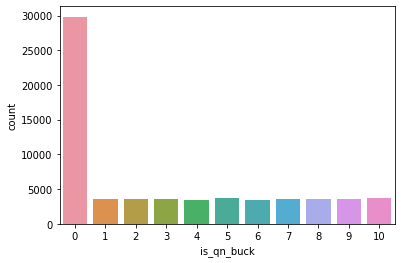

In [13]:
import seaborn as sns
sns.countplot(x="is_qn_buck", data=df_all["train"])

# Data removal for reduce imbalance

In [14]:
train_df = df_all["train"]
valid_df = df_all["valid"]

In [15]:
import random
tr_buck0_num =  int(np.mean([sum(train_df["is_qn_buck"]==key) for key in train_df["is_qn_buck"].unique() if key != 0]))
val_buck0_num = int(np.mean([sum(valid_df["is_qn_buck"]==key) for key in valid_df["is_qn_buck"].unique() if key != 0]))

In [16]:
print(tr_buck0_num)

3589


In [17]:
tr_buckid0 = train_df.index[train_df['is_qn_buck'] == 0]
tr_selected_buck0 = random.sample(train_df.index[train_df['is_qn_buck'] == 0].tolist(), tr_buck0_num)
tr_rm_buck0 = list(set(tr_buckid0)-set(tr_selected_buck0))
val_buckid0 = valid_df.index[valid_df['is_qn_buck'] == 0].tolist()
val_selected_buck0 = random.sample(valid_df.index[valid_df['is_qn_buck'] == 0].tolist(), val_buck0_num)
val_rm_buck0 = list(set(val_buckid0)-set(val_selected_buck0))

In [18]:
print("before", train_df.shape)
train_df.drop(tr_rm_buck0, inplace=True)
valid_df.drop(val_rm_buck0, inplace=True)
print("after", train_df.shape)

before (65719, 7)
after (39485, 7)


<AxesSubplot:xlabel='is_qn_buck', ylabel='count'>

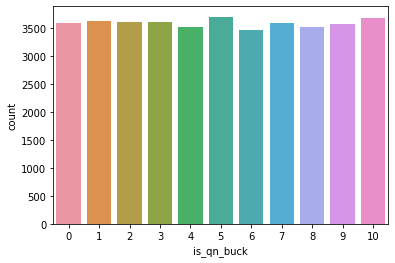

In [19]:
import seaborn as sns
sns.countplot(x="is_qn_buck", data=train_df)

<AxesSubplot:xlabel='is_qn_buck', ylabel='count'>

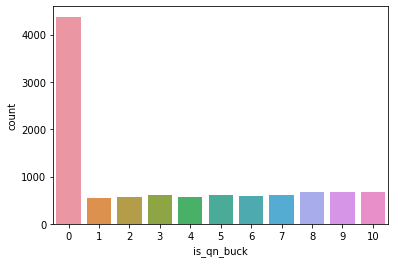

In [20]:
sns.countplot(x="is_qn_buck", data=test_df)

In [21]:
df_all = {
    "train": train_df,
    "valid": valid_df,
    "test": test_df
    }

In [22]:
# for split in ["train", "valid", "test"]:
#     df_all[split].to_csv(f'./data/reduced_msc_bucket{buck_num}_{split}.csv')

# Generate context

In [23]:
special_toks = {k: f"<V{k}>" for k in range(11)}
special_tok_list = [v for k, v in special_toks.items()]
special_tok_list.extend(["<history>", "<persona>", "<agent>", "<user>"])
print(special_tok_list)

['<V0>', '<V1>', '<V2>', '<V3>', '<V4>', '<V5>', '<V6>', '<V7>', '<V8>', '<V9>', '<V10>', '<history>', '<persona>', '<agent>', '<user>']


## load stored dataset

In [24]:
print(buck_num)

10


In [25]:
df_all = {}
for split in ["train", "valid", "test"]:
    df_all[split] = pd.read_csv(f'./data/reduced_msc_bucket{buck_num}_{split}.csv', index_col=0)

In [26]:
df_all["train"].head(5)

,session,history,user_persona,agent_persona,response,is_qn,is_qn_buck
0,session_1,"<user> hi , how are you doing ? i am getting r...",i like canning and whittling . to stay in shap...,i like to remodel homes . i like to go hunting...,you must be very fast . hunting is one of my f...,False,4
2,session_1,"<user> hi , how are you doing ? i am getting r...",i like canning and whittling . to stay in shap...,i like to remodel homes . i like to go hunting...,that is awesome . do you have a favorite seaso...,True,6
3,session_1,"<user> hi , how are you doing ? i am getting r...",i like canning and whittling . to stay in shap...,i like to remodel homes . i like to go hunting...,what is your favorite meat to eat ?,True,6
4,session_1,"<user> hi , how are you doing ? i am getting r...",i like canning and whittling . to stay in shap...,i like to remodel homes . i like to go hunting...,i like chicken or macaroni and cheese .,False,0
5,session_1,"<user> hi , how are you doing ? i am getting r...",i like canning and whittling . to stay in shap...,i like to remodel homes . i like to go hunting...,i am going to watch football . what are you ca...,True,8


### Truncate history and persona

In [27]:
def truncate_history(data, max_hist_len=360):
    if len(data.split())>max_hist_len:
        data = " ".join(data.split()[-max_hist_len:])
    return data

def truncate_persona(data, max_prsn_len=140):
    if len(data.split())>max_prsn_len:
        data = " ".join(data.split()[-max_prsn_len:])
    return data

In [28]:
for split in ["train", "valid", "test"]:
    df_all[split]["truncated_history"] = df_all[split]["history"].apply(truncate_history)
    df_all[split]["truncated_agent_persona"] = df_all[split]["agent_persona"].apply(truncate_persona)
    df_all[split]["truncated_user_persona"] = df_all[split]["user_persona"].apply(truncate_persona)

In [29]:
df_all["train"].head(3)

,session,history,user_persona,agent_persona,response,is_qn,is_qn_buck,truncated_history,truncated_agent_persona,truncated_user_persona
0,session_1,"<user> hi , how are you doing ? i am getting r...",i like canning and whittling . to stay in shap...,i like to remodel homes . i like to go hunting...,you must be very fast . hunting is one of my f...,False,4,"<user> hi , how are you doing ? i am getting r...",i like to remodel homes . i like to go hunting...,i like canning and whittling . to stay in shap...
2,session_1,"<user> hi , how are you doing ? i am getting r...",i like canning and whittling . to stay in shap...,i like to remodel homes . i like to go hunting...,that is awesome . do you have a favorite seaso...,True,6,"<user> hi , how are you doing ? i am getting r...",i like to remodel homes . i like to go hunting...,i like canning and whittling . to stay in shap...
3,session_1,"<user> hi , how are you doing ? i am getting r...",i like canning and whittling . to stay in shap...,i like to remodel homes . i like to go hunting...,what is your favorite meat to eat ?,True,6,"<user> hi , how are you doing ? i am getting r...",i like to remodel homes . i like to go hunting...,i like canning and whittling . to stay in shap...


### Create input sequence for each setting

In [30]:
def gen_context_hist_and_agent(history, aprsn):
     return(f"<history> {history} <persona> {aprsn}")

def gen_qn_feat_code_with_agent(history, aprsn, buck):
     return(f"{special_toks[buck]} <history> {history} <persona> {aprsn}")

def gen_qn_prompt_with_agent(history, aprsn, buck):
     return(f" Generate a question style response by {special_toks[buck]} <history> " + 
            history + " <persona> " + aprsn)

In [31]:
df_all["train"].columns

Index(['session', 'history', 'user_persona', 'agent_persona', 'response',
       'is_qn', 'is_qn_buck', 'truncated_history', 'truncated_agent_persona',
       'truncated_user_persona'],
      dtype='object')

In [32]:
for split in ["train", "valid", "test"]:
    df_all[split]["history_agent_persona"] = df_all[split].apply(lambda x: gen_context_hist_and_agent(
                                                                        x["truncated_history"],
                                                                        x["truncated_agent_persona"]), axis=1)
    df_all[split]["qn_featCode_agent"] = df_all[split].apply(lambda x: gen_qn_feat_code_with_agent(
                                                                        x["truncated_history"],
                                                                        x["truncated_agent_persona"],
                                                                        x["is_qn_buck"]), axis=1)
    df_all[split]["qn_prompt_agent"] = df_all[split].apply(lambda x: gen_qn_prompt_with_agent(
                                                                        x["truncated_history"], 
                                                                        x["truncated_agent_persona"],
                                                                        x["is_qn_buck"]), axis=1)

In [33]:
df_all["train"].head(3)

,session,history,user_persona,agent_persona,response,is_qn,is_qn_buck,truncated_history,truncated_agent_persona,truncated_user_persona,history_agent_persona,qn_featCode_agent,qn_prompt_agent
0,session_1,"<user> hi , how are you doing ? i am getting r...",i like canning and whittling . to stay in shap...,i like to remodel homes . i like to go hunting...,you must be very fast . hunting is one of my f...,False,4,"<user> hi , how are you doing ? i am getting r...",i like to remodel homes . i like to go hunting...,i like canning and whittling . to stay in shap...,"<history> <user> hi , how are you doing ? i am...","<V4> <history> <user> hi , how are you doing ?...",Generate a question style response by <V4> <h...
2,session_1,"<user> hi , how are you doing ? i am getting r...",i like canning and whittling . to stay in shap...,i like to remodel homes . i like to go hunting...,that is awesome . do you have a favorite seaso...,True,6,"<user> hi , how are you doing ? i am getting r...",i like to remodel homes . i like to go hunting...,i like canning and whittling . to stay in shap...,"<history> <user> hi , how are you doing ? i am...","<V6> <history> <user> hi , how are you doing ?...",Generate a question style response by <V6> <h...
3,session_1,"<user> hi , how are you doing ? i am getting r...",i like canning and whittling . to stay in shap...,i like to remodel homes . i like to go hunting...,what is your favorite meat to eat ?,True,6,"<user> hi , how are you doing ? i am getting r...",i like to remodel homes . i like to go hunting...,i like canning and whittling . to stay in shap...,"<history> <user> hi , how are you doing ? i am...","<V6> <history> <user> hi , how are you doing ?...",Generate a question style response by <V6> <h...


In [34]:
for split in ["train", "valid", "test"]:
    df_all[split].to_csv(f'./data/reduced_msc_bucket{buck_num}_{split}.csv')